# Проект для «Викишоп» с BERT

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. Представлен набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**План работы**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

## Подготовка

In [1]:
# ипморт библиотек
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 400)
import warnings
warnings.simplefilter('ignore')

import re

from pymystem3 import Mystem
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

#import spacy
#nlp = spacy.load('en_core_web_sm')

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
#from progress.bar import IncrementalBar
#from tqdm import tqdm
tqdm_notebook.pandas()

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix


import seaborn as sn
import matplotlib.pyplot as plt


import torch
import transformers as ppb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NDSko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [2]:
# загрузка и сохранение данных
toxic_comments = pd.read_csv(r'C:\\dataset_praktikum/toxic_comments.csv')

In [3]:
toxic_comments.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do ...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [4]:
toxic_comments.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
toxic_comments.reset_index().duplicated().sum() # проверка на дубликаты

0

In [7]:
# посмотрим на баланс классов
toxic_comments['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

<font color="blue">
Данные представлены в хорошем качестве. Дубликатов и пропущенных значений нет. Комментарии на английском языке. Присутствует дисбаланс классов в целевом признаке (90/10)</font>

**Лемматезируем текст с помощью WordNetLemmatizer и очистим его от спецсимволов, цифр и лишних пробелов.**

In [8]:
def clear_lemm(text):
    """
    Функция лемматизирует текст и очищает от спецсимволов, цифр и лишних пробелов.
    """
    word_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([WordNetLemmatizer().lemmatize(i) for i in word_list])
    clear_lemm_text = " ".join(re.sub(r'[^a-zA-Z]', ' ', lemm_text).split())
    return clear_lemm_text

In [9]:
toxic_comments['clear_lemm_text'] = toxic_comments['text'].progress_apply(lambda x: clear_lemm(x))
toxic_comments.head()

,text,toxic,clear_lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They were n t vandalism just closure on some GAs after I voted at New York Dolls FAC And please do n t remove the template from the talk page since I m retired now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,D aww He match this background colour I m seemingly stuck with Thanks talk January UTC
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,Hey man I m really not trying to edit war It s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do ...",0,More I ca n t make any real suggestion on improvement I wondered if the section statistic should be later on or a subsection of type of accident I think the reference may need tidying so that they are all in the exact same format ie date format etc I can do that later on if no one else doe first if you have any preference for formatting style on reference or want to do it yourself please let m...
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,You sir are my hero Any chance you remember what page that s on


## Обучение TF-IDF

In [10]:
#Подготовим выборки.
X, y = toxic_comments.drop(['text', 'toxic'], axis=1), toxic_comments['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

Создадим новые признаки с помощью TF-IDF, исключая стоп-слова.

In [11]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
X_train_corpus = X_train['clear_lemm_text'].values.astype('U')
X_train_tf_idf = count_tf_idf.fit_transform(X_train_corpus)
X_test_tf_idf = count_tf_idf.transform(X_test['clear_lemm_text'])

Напишем функцию для обучения моделей и вычисления метрики f1 с кросс-валидацией.

In [12]:
def metric_data(model, name, X_train, y_train, y_test, X_test):
    """
    Функция для обучения модели и подсчета метрик.
    На вход: модель, имя модели.
    Выход: датафрэйм с f1_train, f1_test.
    """
    f1_train = round(cross_val_score(model, X_train, y_train, cv=3, scoring='f1').mean(),3)
    model.fit(X_train, y_train)
    f1_test = round(f1_score(y_test, model.predict(X_test)),3)
    metric = pd.DataFrame({'f1_train': f1_train,
                            'f1_test': f1_test,
                           },
                               index=[name])
    return metric

**LogisticRegression**

In [13]:
model_lr = LogisticRegression(random_state=0, class_weight = 'balanced')

In [14]:
metric_lr = metric_data(model_lr, 'lr', X_train_tf_idf, y_train, y_test, X_test_tf_idf)
metric_lr

,f1_train,f1_test
lr,0.744,0.745


**LinearSVC**

In [15]:
model_LinearSVC = LinearSVC(random_state=0)

In [16]:
metric_LinearSVC = metric_data(model_LinearSVC, 'LinearSVC', X_train_tf_idf, y_train, y_test, X_test_tf_idf)
metric_LinearSVC

,f1_train,f1_test
LinearSVC,0.764,0.771


**CatBoost**

In [17]:
text_features = ['clear_lemm_text']

In [18]:
model_cb = CatBoostClassifier(random_state=0, verbose=100, learning_rate=1, eval_metric='F1', text_features=['clear_lemm_text'])

In [19]:
metric_cb = metric_data(model_cb, 'CatBoost', X_train, y_train, y_test, X_test)
metric_cb

0:	learn: 0.6603106	total: 389ms	remaining: 6m 28s
100:	learn: 0.8305267	total: 23.8s	remaining: 3m 31s
200:	learn: 0.8721413	total: 46.6s	remaining: 3m 5s
300:	learn: 0.8997844	total: 1m 9s	remaining: 2m 41s
400:	learn: 0.9250980	total: 1m 33s	remaining: 2m 20s
500:	learn: 0.9409995	total: 1m 56s	remaining: 1m 56s
600:	learn: 0.9537439	total: 2m 20s	remaining: 1m 32s
700:	learn: 0.9635431	total: 2m 42s	remaining: 1m 9s
800:	learn: 0.9703808	total: 3m 5s	remaining: 46.1s
900:	learn: 0.9773913	total: 3m 28s	remaining: 23s
999:	learn: 0.9812554	total: 3m 51s	remaining: 0us
0:	learn: 0.6630451	total: 192ms	remaining: 3m 11s
100:	learn: 0.8267643	total: 23.1s	remaining: 3m 25s
200:	learn: 0.8692340	total: 45.9s	remaining: 3m 2s
300:	learn: 0.8984962	total: 1m 8s	remaining: 2m 40s
400:	learn: 0.9206985	total: 1m 32s	remaining: 2m 18s
500:	learn: 0.9357246	total: 2m 2s	remaining: 2m 2s
600:	learn: 0.9495032	total: 2m 29s	remaining: 1m 39s
700:	learn: 0.9602756	total: 2m 55s	remaining: 1m 14s

,f1_train,f1_test
CatBoost,0.747,0.754


In [20]:
metric = metric_lr.append(metric_LinearSVC).append(metric_cb)
metric.sort_values('f1_test').style.background_gradient(subset=['f1_test'], cmap='Purples')

,f1_train,f1_test
lr,0.744000,0.745000
CatBoost,0.747000,0.754000
LinearSVC,0.764000,0.771000


<font color="blue">Линейный метод опорных векторов LinearSVC показал лучший результат. Попробуем его улучшить с помощью подбора гиперпараметров.</font>

In [21]:
model = LinearSVC(random_state=0)
param_grid = dict(
    C=[0.01, 0.1, 1, 10],
    class_weight=[None, 'balanced'],
)
gs = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=3)
gs.fit(X_train_tf_idf, y_train)
print('Best F1 Score: %.3f' % gs.best_score_)
print('Best_params: %s' % gs.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.01, class_weight=None .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... C=0.01, class_weight=None, score=0.446, total=   0.9s
[CV] C=0.01, class_weight=None .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ........... C=0.01, class_weight=None, score=0.438, total=   0.8s
[CV] C=0.01, class_weight=None .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] ........... C=0.01, class_weight=None, score=0.447, total=   0.9s
[CV] C=0.01, class_weight=None .......................................
[CV] ........... C=0.01, class_weight=None, score=0.433, total=   0.8s
[CV] C=0.01, class_weight=None .......................................
[CV] ........... C=0.01, class_weight=None, score=0.463, total=   0.8s
[CV] C=0.01, class_weight=balanced ...................................
[CV] ....... C=0.01, class_weight=balanced, score=0.712, total=   0.9s
[CV] C=0.01, class_weight=balanced ...................................
[CV] ....... C=0.01, class_weight=balanced, score=0.703, total=   1.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] ....... C=0.01, class_weight=balanced, score=0.713, total=   1.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] ....... C=0.01, class_weight=balanced, score=0.720, total=   0.9s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.4min finished


Best F1 Score: 0.767
Best_params: {'C': 1, 'class_weight': None}


In [22]:
model_LinearSVC_best_param = LinearSVC(random_state=0, C=1, class_weight=None)
metric_data(model_LinearSVC_best_param, 'LinearSVC_best_param', X_train_tf_idf, y_train, y_test, X_test_tf_idf)

,f1_train,f1_test
LinearSVC_best_param,0.764,0.771


Улучшить результат не получилось.

Посмотрим на матрицу ошибок предсказаний данной модели.

In [23]:
model_LinearSVC_best_param.fit(X_train_tf_idf, y_train)
y_pred = model_LinearSVC_best_param.predict(X_test_tf_idf)

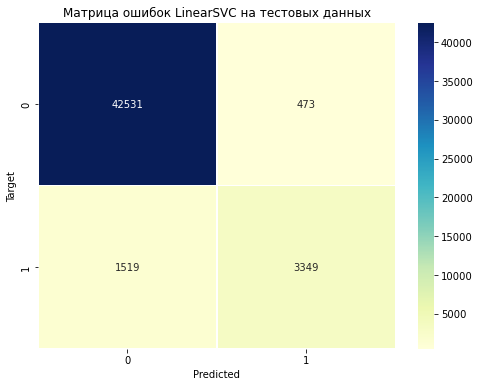

In [24]:
plt.figure(figsize=(8,6))
sn.heatmap(confusion_matrix(y_test, y_pred), linewidths=.5, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.title('Матрица ошибок LinearSVC на тестовых данных')
plt.show()

In [25]:
print('accuracy = ', round(accuracy_score(y_test, y_pred),3))
print('precision = ',round(precision_score(y_test, y_pred),3))
print('recall = ', round(recall_score(y_test, y_pred),3))

accuracy =  0.958
precision =  0.876
recall =  0.688


<font color="blue">
Согласно матрице, общее число ошибок равно 1992 (1519+473). Большая часть из этих ошибок это неправильно размеченные позитивные комментарии. Точность предсказаний = 96 %.</font>

### Обучение с BERT

In [26]:
#Загрузим предобученную модели DistilBERT и токенизатор
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_bert = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
#Для ускорения работы возьмем для проверки только 1000 комментариев и ограничим длину комментариев 512 символами
toxic_comments_bert = toxic_comments.query('toxic==1').sample(100).append(toxic_comments.query('toxic==0').sample(900)).sample(frac=1)
toxic_comments_bert['text'] = toxic_comments_bert['text'].str[:512]

In [28]:
#Проведем токенизацию данных
tokenized = toxic_comments_bert['text'].progress_apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [29]:
#Приведем векторы к одному размеру путем прибавления к более коротким векторам идентификатора 0
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [30]:
#нули не несут значимой информации, отбросим эти токены и укажем нулевые и не нулевые значения
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

(1000, 240)


In [31]:
#Создадим эмбеддинги для комментариев пользователей, ограничив размер батча 20 объектами
batch_size = 20
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:32<00:00, 11.44s/it]


In [32]:
#Запишем все эмбеддинги в матрицу признаков, выделим целевой признак и разделим данные на выборки
features = np.concatenate(embeddings)
target = toxic_comments_bert['toxic']

In [33]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.3, random_state=0, stratify=target)

In [34]:
model_LinearSVC_bert = LinearSVC(random_state=0)
metric_data(model_LinearSVC_bert, 'LinearSVC_bert', features_train, target_train, target_test, features_test)

,f1_train,f1_test
LinearSVC_bert,0.568,0.679


При выборке 1000 комментариев BERT совместно с LinearSVC показал результат хуже чем модели с TF-IDF.

## Выводы

<font color="blue">В данном проекте построена модель для классификации комментариев на позитивные и негативные. Проанализированы несколько моделей (текстовые признаки созданы техникой TF-IDF). Лучший результат в эксперименте показала LinearSVC (f1_test = 0,771).  
Также на небольшом фрагменте данных протестирована модель BERT - результат оказался хуже чем моделях с TF-IDF.</font>